In [1]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
from matplotlib import colors
import matplotlib.path as mpath
import cmocean

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import os

import gsw
import pyresample
from xgcm import Grid

from dask.distributed import Client
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)


In [2]:
client = Client()
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 510.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43037,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 510.00 GiB
Comm: tcp://127.0.0.1:33493,Total threads: 2
Dashboard: /proxy/44063/status,Memory: 72.86 GiB
Nanny: tcp://127.0.0.1:43305,


In [3]:
# read grid file for lon/lat coordinates
dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")
lat_rho_10km= dg.variables["lat_rho"]
lon_rho_10km = dg.variables["lon_rho"]
lat_u_10km= dg.variables["lat_u"]
lon_u_10km = dg.variables["lon_u"]
lat_v_10km= dg.variables["lat_v"]
lon_v_10km = dg.variables["lon_v"]
cor_10km = dg.variables["f"]
pm_10km = dg.variables["pm"]
pn_10km = dg.variables["pn"]
zice_10km = dg.variables["zice"]
h_10km = dg.variables["h"]
dg.close()

In [4]:
%%time

ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_0020.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp= ds.variables["temp"]
salt= ds.variables["salt"]
zeta= ds.variables["zeta"]
melt= ds.variables["m"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
# calc dz:
hwater = ds.h -abs(ds.zice) # replace ds.h for hwater below
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
z_rho = ds.zeta + (ds.zeta + hwater) * Zo_rho -abs(ds.zice)
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * hwater) / (ds.hc + hwater)
z_w = ds.zeta + (ds.zeta + hwater) * Zo_w -abs(ds.zice)
del Zo_rho, Zo_w

ds.close()




CPU times: user 364 ms, sys: 134 ms, total: 498 ms
Wall time: 736 ms


In [5]:
# load pre-saved cross sections:
cs_path = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross-sections/'

# AmudS
# 105W and 115W
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-105.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_105W= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-105.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_105W= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-105.0_WAOM10_ModDragA.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_105W_mdA= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-105.0_WAOM10_ModDragA.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_105W_mdA= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-105.0_WAOM10_ModDragB.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_105W_mdB= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-105.0_WAOM10_ModDragB.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_105W_mdB= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-105.0_WAOM10_ModDragC.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_105W_mdC= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-105.0_WAOM10_ModDragC.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_105W_mdC= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-105.0_WAOM10_ModDragD.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_105W_mdD= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-105.0_WAOM10_ModDragD.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_105W_mdD= ds.variables["Hz"]
ds.close()

ds = xr.open_mfdataset(paths=cs_path + 'Lat_cross-sec_-105.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Lat_105W= ds.variables["latitude_rho"]
ds.close()

ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-110.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_110W= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-110.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_110W= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-110.0_WAOM10_ModDragA.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_110W_mdA= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-110.0_WAOM10_ModDragA.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_110W_mdA= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-110.0_WAOM10_ModDragB.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_110W_mdB= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-110.0_WAOM10_ModDragB.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_110W_mdB= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-110.0_WAOM10_ModDragC.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_110W_mdC= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-110.0_WAOM10_ModDragC.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_110W_mdC= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-110.0_WAOM10_ModDragD.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_110W_mdD= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-110.0_WAOM10_ModDragD.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_110W_mdD= ds.variables["Hz"]
ds.close()

ds = xr.open_mfdataset(paths=cs_path + 'Lat_cross-sec_-110.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Lat_110W= ds.variables["latitude_rho"]
ds.close()

ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-115.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_115W= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-115.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_115W= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-115.0_WAOM10_ModDragA.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_115W_mdA= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-115.0_WAOM10_ModDragA.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_115W_mdA= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-115.0_WAOM10_ModDragB.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_115W_mdB= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-115.0_WAOM10_ModDragB.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_115W_mdB= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-115.0_WAOM10_ModDragC.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_115W_mdC= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-115.0_WAOM10_ModDragC.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_115W_mdC= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-115.0_WAOM10_ModDragD.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_115W_mdD= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-115.0_WAOM10_ModDragD.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_115W_mdD= ds.variables["Hz"]
ds.close()

ds = xr.open_mfdataset(paths=cs_path + 'Lat_cross-sec_-115.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Lat_115W= ds.variables["latitude_rho"]
ds.close()


In [6]:

# BellS
# 95W and 80W

ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-80.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_80W= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-80.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_80W= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-80.0_WAOM10_ModDragA.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_80W_mdA= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-80.0_WAOM10_ModDragA.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_80W_mdA= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-80.0_WAOM10_ModDragB.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_80W_mdB= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-80.0_WAOM10_ModDragB.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_80W_mdB= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-80.0_WAOM10_ModDragC.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_80W_mdC= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-80.0_WAOM10_ModDragC.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_80W_mdC= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-80.0_WAOM10_ModDragD.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_80W_mdD= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-80.0_WAOM10_ModDragD.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_80W_mdD= ds.variables["Hz"]
ds.close()

ds = xr.open_mfdataset(paths=cs_path + 'Lat_cross-sec_-80.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Lat_80W= ds.variables["latitude_rho"]
ds.close()

ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-85.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_85W= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-85.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_85W= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-85.0_WAOM10_ModDragA.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_85W_mdA= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-85.0_WAOM10_ModDragA.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_85W_mdA= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-85.0_WAOM10_ModDragB.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_85W_mdB= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-85.0_WAOM10_ModDragB.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_85W_mdB= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-85.0_WAOM10_ModDragC.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_85W_mdC= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-85.0_WAOM10_ModDragC.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_85W_mdC= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-85.0_WAOM10_ModDragD.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_85W_mdD= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-85.0_WAOM10_ModDragD.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_85W_mdD= ds.variables["Hz"]
ds.close()

ds = xr.open_mfdataset(paths=cs_path + 'Lat_cross-sec_-85.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Lat_85W= ds.variables["latitude_rho"]
ds.close()

ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-95.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_95W= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-95.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_95W= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-95.0_WAOM10_ModDragA.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_95W_mdA= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-95.0_WAOM10_ModDragA.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_95W_mdA= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-95.0_WAOM10_ModDragB.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_95W_mdB= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-95.0_WAOM10_ModDragB.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_95W_mdB= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-95.0_WAOM10_ModDragC.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_95W_mdC= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-95.0_WAOM10_ModDragC.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_95W_mdC= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-95.0_WAOM10_ModDragD.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_95W_mdD= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-95.0_WAOM10_ModDragD.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_95W_mdD= ds.variables["Hz"]
ds.close()

ds = xr.open_mfdataset(paths=cs_path + 'Lat_cross-sec_-95.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Lat_95W= ds.variables["latitude_rho"]
ds.close()



In [7]:

# Ross
# 158W and 165W

ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-158.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_158W= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-158.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_158W= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-158.0_WAOM10_ModDragA.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_158W_mdA= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-158.0_WAOM10_ModDragA.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_158W_mdA= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-158.0_WAOM10_ModDragB.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_158W_mdB= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-158.0_WAOM10_ModDragB.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_158W_mdB= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-158.0_WAOM10_ModDragC.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_158W_mdC= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-158.0_WAOM10_ModDragC.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_158W_mdC= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-158.0_WAOM10_ModDragD.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_158W_mdD= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-158.0_WAOM10_ModDragD.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_158W_mdD= ds.variables["Hz"]
ds.close()

ds = xr.open_mfdataset(paths=cs_path + 'Lat_cross-sec_-158.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Lat_158W= ds.variables["latitude_rho"]
ds.close()

ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-160.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_160W= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-160.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_160W= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-160.0_WAOM10_ModDragA.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_160W_mdA= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-160.0_WAOM10_ModDragA.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_160W_mdA= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-160.0_WAOM10_ModDragB.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_160W_mdB= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-160.0_WAOM10_ModDragB.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_160W_mdB= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-160.0_WAOM10_ModDragC.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_160W_mdC= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-160.0_WAOM10_ModDragC.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_160W_mdC= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-160.0_WAOM10_ModDragD.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_160W_mdD= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-160.0_WAOM10_ModDragD.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_160W_mdD= ds.variables["Hz"]
ds.close()

ds = xr.open_mfdataset(paths=cs_path + 'Lat_cross-sec_-160.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Lat_160W= ds.variables["latitude_rho"]
ds.close()

ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-165.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_165W= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-165.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_165W= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-165.0_WAOM10_ModDragA.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_165W_mdA= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-165.0_WAOM10_ModDragA.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_165W_mdA= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-165.0_WAOM10_ModDragB.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_165W_mdB= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-165.0_WAOM10_ModDragB.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_165W_mdB= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-165.0_WAOM10_ModDragC.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_165W_mdC= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-165.0_WAOM10_ModDragC.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_165W_mdC= ds.variables["Hz"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Temp_cross-sec_-165.0_WAOM10_ModDragD.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_165W_mdD= ds.variables["temp"]
ds.close()
ds = xr.open_mfdataset(paths=cs_path + 'Hz_cross-sec_-165.0_WAOM10_ModDragD.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Hz_165W_mdD= ds.variables["Hz"]
ds.close()

ds = xr.open_mfdataset(paths=cs_path + 'Lat_cross-sec_-165.0_WAOM10.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
Lat_165W= ds.variables["latitude_rho"]
ds.close()




# plots


In [8]:
fig_path='/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Cross_sections/'


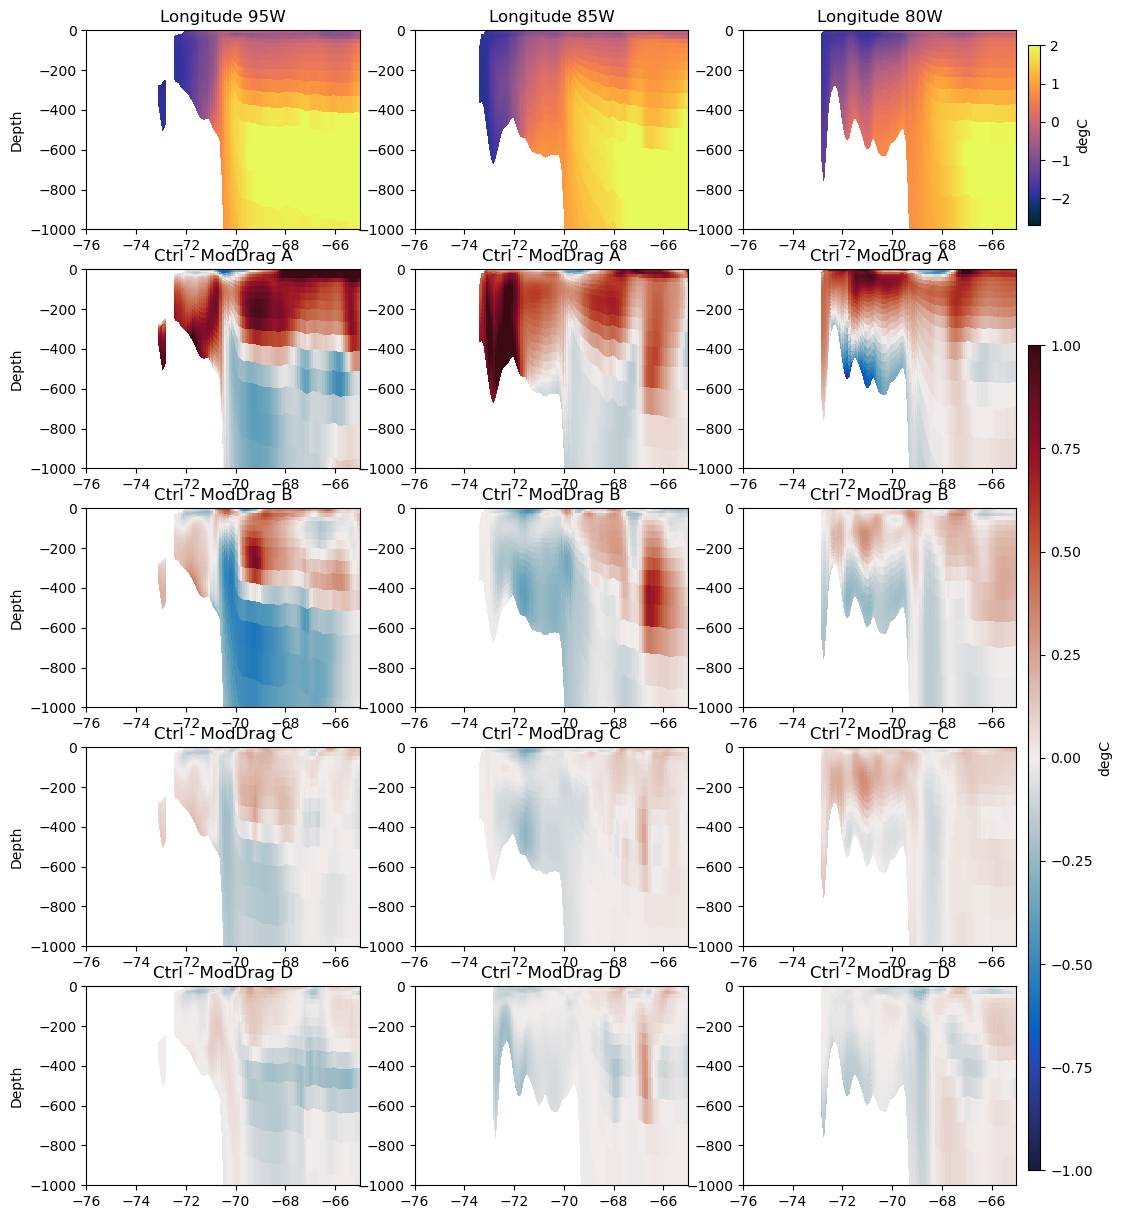

In [9]:
tmin=-2.7
tmax=2
atmin=-1
atmax=1

fig, ax = plt.subplots(nrows=5, ncols=3, figsize = (12, 15))

ct=ax[0,2].pcolor(Lat_80W,np.nanmean(Hz_80W,axis=0),np.nanmean(temp_80W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
# ax[0,2].set_ylabel('Depth')
ax[0,2].set_ylim(-1000,0)
ax[0,2].set_xlim(-76,-65)
ax[0,2].set_title('Longitude 80W')

ct=ax[0,1].pcolor(Lat_85W,np.nanmean(Hz_85W,axis=0),np.nanmean(temp_85W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
ax[0,1].set_ylim(-1000,0)
ax[0,1].set_xlim(-76,-65)
ax[0,1].set_title('Longitude 85W')

ct=ax[0,0].pcolor(Lat_95W,np.nanmean(Hz_95W,axis=0),np.nanmean(temp_95W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
ax[0,0].set_ylabel('Depth')
ax[0,0].set_ylim(-1000,0)
ax[0,0].set_xlim(-76,-65)
ax[0,0].set_title('Longitude 95W')

cbar_ax0= fig.add_axes([0.91, 0.75,  0.01, 0.12])
fig.colorbar(ct, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('degC')#, labelpad=-35)

## anomlies:
# ModDrag A
temp_diff = -(np.nanmean(temp_80W,axis=0)+273.15) + (np.nanmean(temp_80W_mdA,axis=0)+273.15)
cta=ax[1,2].pcolor(Lat_80W,np.nanmean(Hz_80W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[1,2].set_ylabel('Depth')
ax[1,2].set_ylim(-1000,0)
ax[1,2].set_xlim(-76,-65)
ax[1,2].set_title('Ctrl - ModDrag A')

# ModDrag B
temp_diff = -(np.nanmean(temp_80W,axis=0)+273.15) + (np.nanmean(temp_80W_mdB,axis=0)+273.15)
cta=ax[2,2].pcolor(Lat_80W,np.nanmean(Hz_80W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[2,2].set_ylabel('Depth')
ax[2,2].set_ylim(-1000,0)
ax[2,2].set_xlim(-76,-65)
ax[2,2].set_title('Ctrl - ModDrag B')

# ModDrag C
temp_diff = -(np.nanmean(temp_80W,axis=0)+273.15) + (np.nanmean(temp_80W_mdC,axis=0)+273.15)
cta=ax[3,2].pcolor(Lat_80W,np.nanmean(Hz_80W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[3,2].set_ylabel('Depth')
ax[3,2].set_ylim(-1000,0)
ax[3,2].set_xlim(-76,-65)
ax[3,2].set_title('Ctrl - ModDrag C')

# ModDrag D
temp_diff = -(np.nanmean(temp_80W,axis=0)+273.15) + (np.nanmean(temp_80W_mdD,axis=0)+273.15)
cta=ax[4,2].pcolor(Lat_80W,np.nanmean(Hz_80W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[4,2].set_ylabel('Depth')
ax[4,2].set_ylim(-1000,0)
ax[4,2].set_xlim(-76,-65)
ax[4,2].set_title('Ctrl - ModDrag D')

## 85:
# ModDrag A
temp_diff = -(np.nanmean(temp_85W,axis=0)+273.15) + (np.nanmean(temp_85W_mdA,axis=0)+273.15)
cta=ax[1,1].pcolor(Lat_85W,np.nanmean(Hz_85W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[1,1].set_ylabel('Depth')
ax[1,1].set_ylim(-1000,0)
ax[1,1].set_xlim(-76,-65)
ax[1,1].set_title('Ctrl - ModDrag A')

# ModDrag B
temp_diff = -(np.nanmean(temp_85W,axis=0)+273.15) + (np.nanmean(temp_85W_mdB,axis=0)+273.15)
cta=ax[2,1].pcolor(Lat_85W,np.nanmean(Hz_85W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[2,1].set_ylabel('Depth')
ax[2,1].set_ylim(-1000,0)
ax[2,1].set_xlim(-76,-65)
ax[2,1].set_title('Ctrl - ModDrag B')

# ModDrag C
temp_diff = -(np.nanmean(temp_85W,axis=0)+273.15) + (np.nanmean(temp_85W_mdC,axis=0)+273.15)
cta=ax[3,1].pcolor(Lat_85W,np.nanmean(Hz_85W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[3,1].set_ylabel('Depth')
ax[3,1].set_ylim(-1000,0)
ax[3,1].set_xlim(-76,-65)
ax[3,1].set_title('Ctrl - ModDrag C')

# ModDrag D
temp_diff = -(np.nanmean(temp_85W,axis=0)+273.15) + (np.nanmean(temp_85W_mdD,axis=0)+273.15)
cta=ax[4,1].pcolor(Lat_80W,np.nanmean(Hz_80W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[4,1].set_ylabel('Depth')
ax[4,1].set_ylim(-1000,0)
ax[4,1].set_xlim(-76,-65)
ax[4,1].set_title('Ctrl - ModDrag D')

# 95W
temp_diff = -(np.nanmean(temp_95W,axis=0)+273.15) + (np.nanmean(temp_95W_mdA,axis=0)+273.15)
cta=ax[1,0].pcolor(Lat_95W,np.nanmean(Hz_95W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
ax[1,0].set_ylabel('Depth')
ax[1,0].set_ylim(-1000,0)
ax[1,0].set_xlim(-76,-65)
ax[1,0].set_title('Ctrl - ModDrag A')

# ModDrag B
temp_diff = -(np.nanmean(temp_95W,axis=0)+273.15) + (np.nanmean(temp_95W_mdB,axis=0)+273.15)
cta=ax[2,0].pcolor(Lat_95W,np.nanmean(Hz_95W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
ax[2,0].set_ylabel('Depth')
ax[2,0].set_ylim(-1000,0)
ax[2,0].set_xlim(-76,-65)
ax[2,0].set_title('Ctrl - ModDrag B')

# ModDrag C
temp_diff = -(np.nanmean(temp_95W,axis=0)+273.15) + (np.nanmean(temp_95W_mdC,axis=0)+273.15)
cta=ax[3,0].pcolor(Lat_95W,np.nanmean(Hz_95W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
ax[3,0].set_ylabel('Depth')
ax[3,0].set_ylim(-1000,0)
ax[3,0].set_xlim(-76,-65)
ax[3,0].set_title('Ctrl - ModDrag C')

# ModDrag D
temp_diff = -(np.nanmean(temp_95W,axis=0)+273.15) + (np.nanmean(temp_95W_mdD,axis=0)+273.15)
cta=ax[4,0].pcolor(Lat_95W,np.nanmean(Hz_95W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
ax[4,0].set_ylabel('Depth')
ax[4,0].set_ylim(-1000,0)
ax[4,0].set_xlim(-76,-65)
ax[4,0].set_title('Ctrl - ModDrag D')

cbar_ax1= fig.add_axes([0.91, 0.12,  0.01, 0.55])
fig.colorbar(cta, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('degC')#, labelpad=-35)

name_fig='waom10_ModDrag_expts_BellS-sections_yr10.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')

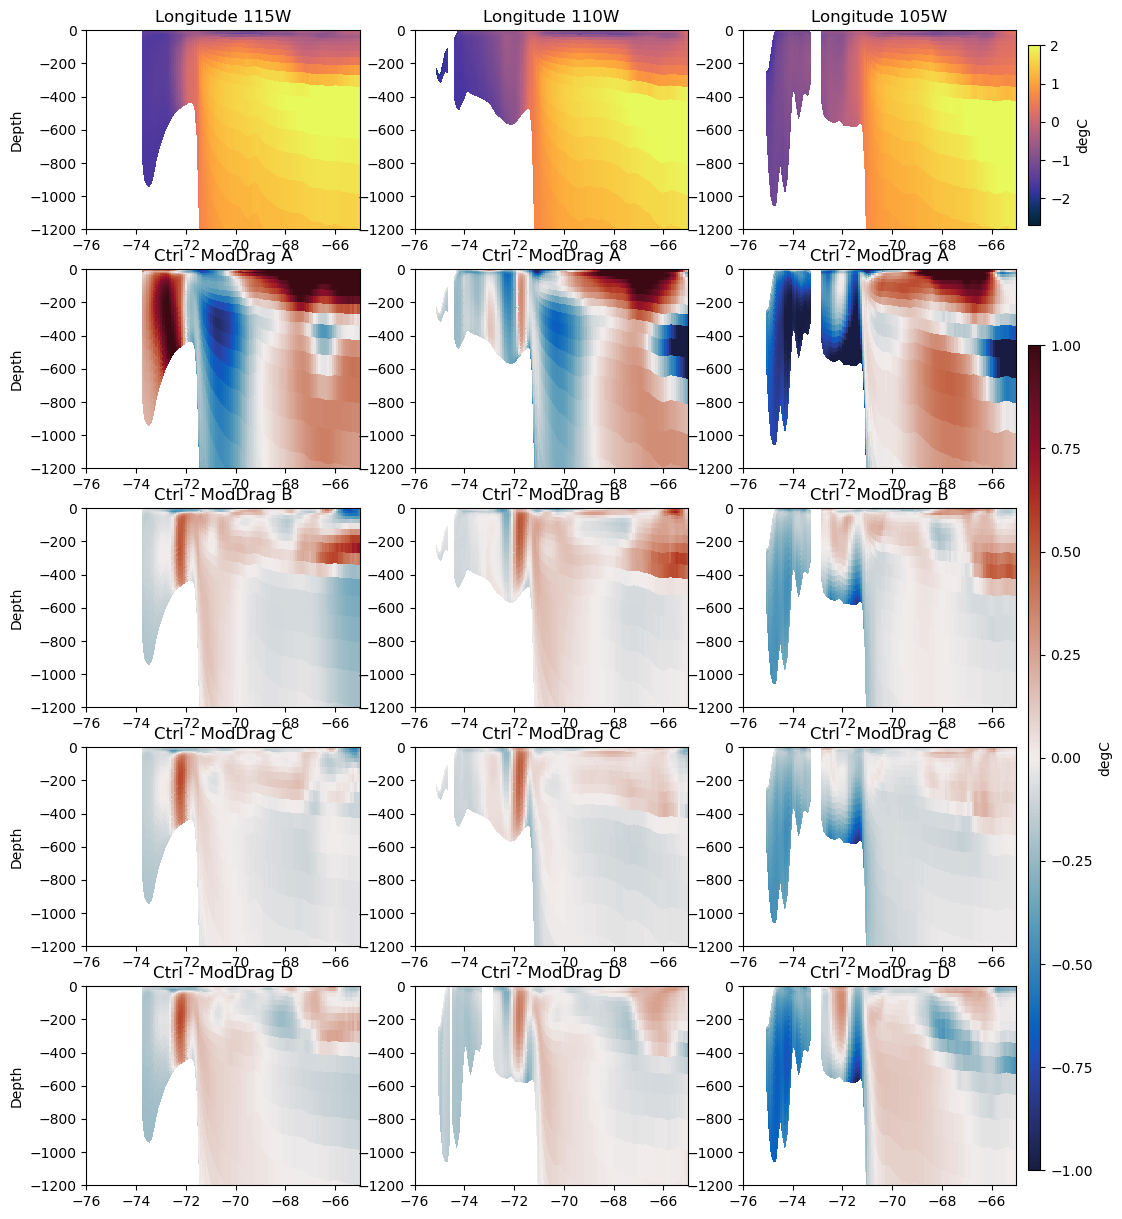

In [10]:
tmin=-2.7
tmax=2
atmin=-1
atmax=1

fig, ax = plt.subplots(nrows=5, ncols=3, figsize = (12, 15))

ct=ax[0,2].pcolor(Lat_105W,np.nanmean(Hz_105W,axis=0),np.nanmean(temp_105W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
# ax[0,2].set_ylabel('Depth')
ax[0,2].set_ylim(-1200,0)
ax[0,2].set_xlim(-76,-65)
ax[0,2].set_title('Longitude 105W')

ct=ax[0,1].pcolor(Lat_110W,np.nanmean(Hz_110W,axis=0),np.nanmean(temp_110W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
ax[0,1].set_ylim(-1200,0)
ax[0,1].set_xlim(-76,-65)
ax[0,1].set_title('Longitude 110W')

ct=ax[0,0].pcolor(Lat_115W,np.nanmean(Hz_115W,axis=0),np.nanmean(temp_115W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
ax[0,0].set_ylabel('Depth')
ax[0,0].set_ylim(-1200,0)
ax[0,0].set_xlim(-76,-65)
ax[0,0].set_title('Longitude 115W')

cbar_ax0= fig.add_axes([0.91, 0.75,  0.01, 0.12])
fig.colorbar(ct, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('degC')#, labelpad=-35)

## anomlies:
# ModDrag A
temp_diff = -(np.nanmean(temp_105W,axis=0)+273.15) + (np.nanmean(temp_105W_mdA,axis=0)+273.15)
cta=ax[1,2].pcolor(Lat_105W,np.nanmean(Hz_105W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[1,2].set_ylabel('Depth')
ax[1,2].set_ylim(-1200,0)
ax[1,2].set_xlim(-76,-65)
ax[1,2].set_title('Ctrl - ModDrag A')

# ModDrag B
temp_diff = -(np.nanmean(temp_105W,axis=0)+273.15) + (np.nanmean(temp_105W_mdB,axis=0)+273.15)
cta=ax[2,2].pcolor(Lat_105W,np.nanmean(Hz_105W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[2,2].set_ylabel('Depth')
ax[2,2].set_ylim(-1200,0)
ax[2,2].set_xlim(-76,-65)
ax[2,2].set_title('Ctrl - ModDrag B')

# ModDrag C
temp_diff = -(np.nanmean(temp_105W,axis=0)+273.15) + (np.nanmean(temp_105W_mdC,axis=0)+273.15)
cta=ax[3,2].pcolor(Lat_105W,np.nanmean(Hz_105W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[3,2].set_ylabel('Depth')
ax[3,2].set_ylim(-1200,0)
ax[3,2].set_xlim(-76,-65)
ax[3,2].set_title('Ctrl - ModDrag C')

# ModDrag D
temp_diff = -(np.nanmean(temp_105W,axis=0)+273.15) + (np.nanmean(temp_105W_mdD,axis=0)+273.15)
cta=ax[4,2].pcolor(Lat_105W,np.nanmean(Hz_105W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[4,2].set_ylabel('Depth')
ax[4,2].set_ylim(-1200,0)
ax[4,2].set_xlim(-76,-65)
ax[4,2].set_title('Ctrl - ModDrag D')

## 110:
# ModDrag A
temp_diff = -(np.nanmean(temp_110W,axis=0)+273.15) + (np.nanmean(temp_110W_mdA,axis=0)+273.15)
cta=ax[1,1].pcolor(Lat_110W,np.nanmean(Hz_110W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[1,1].set_ylabel('Depth')
ax[1,1].set_ylim(-1200,0)
ax[1,1].set_xlim(-76,-65)
ax[1,1].set_title('Ctrl - ModDrag A')

# ModDrag B
temp_diff = -(np.nanmean(temp_110W,axis=0)+273.15) + (np.nanmean(temp_110W_mdB,axis=0)+273.15)
cta=ax[2,1].pcolor(Lat_110W,np.nanmean(Hz_110W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[2,1].set_ylabel('Depth')
ax[2,1].set_ylim(-1200,0)
ax[2,1].set_xlim(-76,-65)
ax[2,1].set_title('Ctrl - ModDrag B')

# ModDrag C
temp_diff = -(np.nanmean(temp_110W,axis=0)+273.15) + (np.nanmean(temp_110W_mdC,axis=0)+273.15)
cta=ax[3,1].pcolor(Lat_110W,np.nanmean(Hz_110W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[3,1].set_ylabel('Depth')
ax[3,1].set_ylim(-1200,0)
ax[3,1].set_xlim(-76,-65)
ax[3,1].set_title('Ctrl - ModDrag C')

# ModDrag D
temp_diff = -(np.nanmean(temp_110W,axis=0)+273.15) + (np.nanmean(temp_110W_mdD,axis=0)+273.15)
cta=ax[4,1].pcolor(Lat_105W,np.nanmean(Hz_105W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[4,1].set_ylabel('Depth')
ax[4,1].set_ylim(-1200,0)
ax[4,1].set_xlim(-76,-65)
ax[4,1].set_title('Ctrl - ModDrag D')

# 115W
temp_diff = -(np.nanmean(temp_115W,axis=0)+273.15) + (np.nanmean(temp_115W_mdA,axis=0)+273.15)
cta=ax[1,0].pcolor(Lat_115W,np.nanmean(Hz_115W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
ax[1,0].set_ylabel('Depth')
ax[1,0].set_ylim(-1200,0)
ax[1,0].set_xlim(-76,-65)
ax[1,0].set_title('Ctrl - ModDrag A')

# ModDrag B
temp_diff = -(np.nanmean(temp_115W,axis=0)+273.15) + (np.nanmean(temp_115W_mdB,axis=0)+273.15)
cta=ax[2,0].pcolor(Lat_115W,np.nanmean(Hz_115W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
ax[2,0].set_ylabel('Depth')
ax[2,0].set_ylim(-1200,0)
ax[2,0].set_xlim(-76,-65)
ax[2,0].set_title('Ctrl - ModDrag B')

# ModDrag C
temp_diff = -(np.nanmean(temp_115W,axis=0)+273.15) + (np.nanmean(temp_115W_mdC,axis=0)+273.15)
cta=ax[3,0].pcolor(Lat_115W,np.nanmean(Hz_115W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
ax[3,0].set_ylabel('Depth')
ax[3,0].set_ylim(-1200,0)
ax[3,0].set_xlim(-76,-65)
ax[3,0].set_title('Ctrl - ModDrag C')

# ModDrag D
temp_diff = -(np.nanmean(temp_115W,axis=0)+273.15) + (np.nanmean(temp_115W_mdD,axis=0)+273.15)
cta=ax[4,0].pcolor(Lat_115W,np.nanmean(Hz_115W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
ax[4,0].set_ylabel('Depth')
ax[4,0].set_ylim(-1200,0)
ax[4,0].set_xlim(-76,-65)
ax[4,0].set_title('Ctrl - ModDrag D')

cbar_ax1= fig.add_axes([0.91, 0.12,  0.01, 0.55])
fig.colorbar(cta, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('degC')#, labelpad=-35)

name_fig='waom10_ModDrag_expts_AmudS-sections_yr10.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')

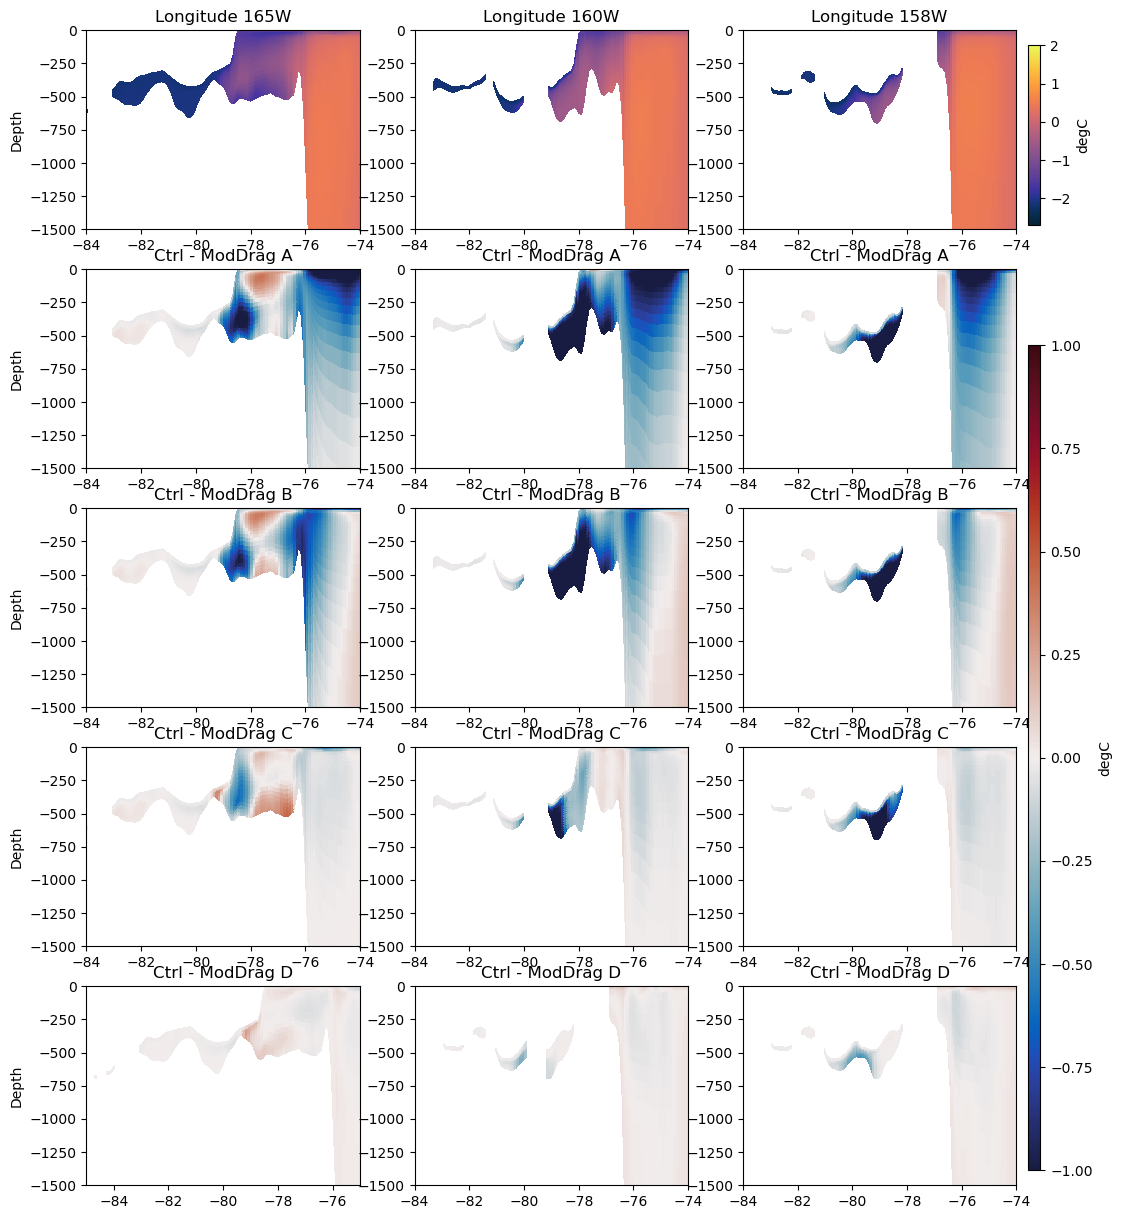

In [11]:
tmin=-2.7
tmax=2
atmin=-1
atmax=1

fig, ax = plt.subplots(nrows=5, ncols=3, figsize = (12, 15))

ct=ax[0,2].pcolor(Lat_158W,np.nanmean(Hz_158W,axis=0),np.nanmean(temp_158W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
# ax[0,2].set_ylabel('Depth')
ax[0,2].set_ylim(-1500,0)
ax[0,2].set_xlim(-84,-74)
ax[0,2].set_title('Longitude 158W')

ct=ax[0,1].pcolor(Lat_160W,np.nanmean(Hz_160W,axis=0),np.nanmean(temp_160W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
ax[0,1].set_ylim(-1500,0)
ax[0,1].set_xlim(-84,-74)
ax[0,1].set_title('Longitude 160W')

ct=ax[0,0].pcolor(Lat_165W,np.nanmean(Hz_165W,axis=0),np.nanmean(temp_165W,axis=0), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
ax[0,0].set_ylabel('Depth')
ax[0,0].set_ylim(-1500,0)
ax[0,0].set_xlim(-84,-74)
ax[0,0].set_title('Longitude 165W')

cbar_ax0= fig.add_axes([0.91, 0.75,  0.01, 0.12])
fig.colorbar(ct, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('degC')#, labelpad=-35)

## anomlies:
# ModDrag A
temp_diff = -(np.nanmean(temp_158W,axis=0)+273.15) + (np.nanmean(temp_158W_mdA,axis=0)+273.15)
cta=ax[1,2].pcolor(Lat_158W,np.nanmean(Hz_158W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[1,2].set_ylabel('Depth')
ax[1,2].set_ylim(-1500,0)
ax[1,2].set_xlim(-84,-74)
ax[1,2].set_title('Ctrl - ModDrag A')

# ModDrag B
temp_diff = -(np.nanmean(temp_158W,axis=0)+273.15) + (np.nanmean(temp_158W_mdB,axis=0)+273.15)
cta=ax[2,2].pcolor(Lat_158W,np.nanmean(Hz_158W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[2,2].set_ylabel('Depth')
ax[2,2].set_ylim(-1500,0)
ax[2,2].set_xlim(-84,-74)
ax[2,2].set_title('Ctrl - ModDrag B')

# ModDrag C
temp_diff = -(np.nanmean(temp_158W,axis=0)+273.15) + (np.nanmean(temp_158W_mdC,axis=0)+273.15)
cta=ax[3,2].pcolor(Lat_158W,np.nanmean(Hz_158W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[3,2].set_ylabel('Depth')
ax[3,2].set_ylim(-1500,0)
ax[3,2].set_xlim(-84,-74)
ax[3,2].set_title('Ctrl - ModDrag C')

# ModDrag D
temp_diff = -(np.nanmean(temp_158W,axis=0)+273.15) + (np.nanmean(temp_158W_mdD,axis=0)+273.15)
cta=ax[4,2].pcolor(Lat_158W,np.nanmean(Hz_158W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[4,2].set_ylabel('Depth')
ax[4,2].set_ylim(-1500,0)
ax[4,2].set_xlim(-84,-74)
ax[4,2].set_title('Ctrl - ModDrag D')

## 160:
# ModDrag A
temp_diff = -(np.nanmean(temp_160W,axis=0)+273.15) + (np.nanmean(temp_160W_mdA,axis=0)+273.15)
cta=ax[1,1].pcolor(Lat_160W,np.nanmean(Hz_160W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[1,1].set_ylabel('Depth')
ax[1,1].set_ylim(-1500,0)
ax[1,1].set_xlim(-84,-74)
ax[1,1].set_title('Ctrl - ModDrag A')

# ModDrag B
temp_diff = -(np.nanmean(temp_160W,axis=0)+273.15) + (np.nanmean(temp_160W_mdB,axis=0)+273.15)
cta=ax[2,1].pcolor(Lat_160W,np.nanmean(Hz_160W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[2,1].set_ylabel('Depth')
ax[2,1].set_ylim(-1500,0)
ax[2,1].set_xlim(-84,-74)
ax[2,1].set_title('Ctrl - ModDrag B')

# ModDrag C
temp_diff = -(np.nanmean(temp_160W,axis=0)+273.15) + (np.nanmean(temp_160W_mdC,axis=0)+273.15)
cta=ax[3,1].pcolor(Lat_160W,np.nanmean(Hz_160W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[3,1].set_ylabel('Depth')
ax[3,1].set_ylim(-1500,0)
ax[3,1].set_xlim(-84,-74)
ax[3,1].set_title('Ctrl - ModDrag C')

# ModDrag D
temp_diff = -(np.nanmean(temp_160W,axis=0)+273.15) + (np.nanmean(temp_160W_mdD,axis=0)+273.15)
cta=ax[4,1].pcolor(Lat_158W,np.nanmean(Hz_158W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
# ax[4,1].set_ylabel('Depth')
ax[4,1].set_ylim(-1500,0)
ax[4,1].set_xlim(-84,-74)
ax[4,1].set_title('Ctrl - ModDrag D')

# 165W
temp_diff = -(np.nanmean(temp_165W,axis=0)+273.15) + (np.nanmean(temp_165W_mdA,axis=0)+273.15)
cta=ax[1,0].pcolor(Lat_165W,np.nanmean(Hz_165W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
ax[1,0].set_ylabel('Depth')
ax[1,0].set_ylim(-1500,0)
ax[1,0].set_xlim(-84,-74)
ax[1,0].set_title('Ctrl - ModDrag A')

# ModDrag B
temp_diff = -(np.nanmean(temp_165W,axis=0)+273.15) + (np.nanmean(temp_165W_mdB,axis=0)+273.15)
cta=ax[2,0].pcolor(Lat_165W,np.nanmean(Hz_165W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
ax[2,0].set_ylabel('Depth')
ax[2,0].set_ylim(-1500,0)
ax[2,0].set_xlim(-84,-74)
ax[2,0].set_title('Ctrl - ModDrag B')

# ModDrag C
temp_diff = -(np.nanmean(temp_165W,axis=0)+273.15) + (np.nanmean(temp_165W_mdC,axis=0)+273.15)
cta=ax[3,0].pcolor(Lat_165W,np.nanmean(Hz_165W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
ax[3,0].set_ylabel('Depth')
ax[3,0].set_ylim(-1500,0)
ax[3,0].set_xlim(-84,-74)
ax[3,0].set_title('Ctrl - ModDrag C')

# ModDrag D
temp_diff = -(np.nanmean(temp_165W,axis=0)+273.15) + (np.nanmean(temp_165W_mdD,axis=0)+273.15)
cta=ax[4,0].pcolor(Lat_165W,np.nanmean(Hz_165W,axis=0),temp_diff, cmap=cmocean.cm.balance, vmin=atmin, vmax=atmax)
ax[4,0].set_ylabel('Depth')
ax[4,0].set_ylim(-1500,0)
ax[4,0].set_xlim(-85,-75)
ax[4,0].set_title('Ctrl - ModDrag D')

cbar_ax1= fig.add_axes([0.91, 0.12,  0.01, 0.55])
fig.colorbar(cta, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('degC')#, labelpad=-35)

name_fig='waom10_ModDrag_expts_RossSea-sections_yr10.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')